In [259]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import talib


sns.set_style("whitegrid")


# Start
This analysis only works for "highly volatile" periods, for mad bull/bear periods the statistics may not be useful (for cases that"re sticking around bollinger upper/lower band). 

In [305]:
ticker = "pltr"
# trading days a year ~250d
data = yf.download(ticker, period="1500d", interval="1d", progress=False)

def extrema_analysis(data):
    additional_day = data.iloc[-1].name + pd.Timedelta(days=1)
    data.loc[additional_day] = data.iloc[-1].Close

    drop_col = []
    rise_col = []

    data["1d_trend"] = 2 * data["Close"] - data["Open"] - data["Open"].shift(1)

    # looks into future to see max drawdown
    for i in [1,2,3,4,5]:
        # consider the extreme drop from high, catch the ending point (final close - initial low)
        data[f"{i}d_drop_ext"] = (data["Low"] - data["High"].shift(i)) / data["High"].shift(i)
        data[f"{i}d_drop_next"] = (data["Close"].shift(-1) - data["High"].shift(i)) / data["High"].shift(i)
        drop_col.extend([f"{i}d_drop_ext", f"{i}d_drop_next"])

        # consider the extreme rebounce from low, catch the ending point (final close - initial low)
        data[f"{i}d_rise_ext"] = (data["High"] - data["Low"].shift(i)) / data["Low"].shift(i)
        data[f"{i}d_rise_next"] = (data["Close"].shift(-1) - data["Low"].shift(i)) / data["Low"].shift(i)
        rise_col.extend([f"{i}d_rise_ext", f"{i}d_rise_next"])

    data["up"], _, data["low"] = talib.BBANDS(data["Close"], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)

    data["drop_flag"] = data["1d_drop_ext"] < data["1d_drop_ext"].quantile(.1)
    data["drop_025"] = data["High"].shift(1) * (1 + data["2d_drop_ext"].quantile(.025))
    data["drop_005"] = data["High"].shift(1) * (1 + data["2d_drop_ext"].quantile(.005))

    data["rise_flag"] = data["1d_rise_ext"] > data["1d_rise_ext"].quantile(.9)
    data["rise_025"] = data["Low"].shift(1) * (1 + data["2d_rise_ext"].quantile(.975))
    data["rise_005"] = data["Low"].shift(1) * (1 + data["2d_rise_ext"].quantile(.995))

    # 1d_trend drop, expect rebounce (no rise_flag allowed); 1d_trend rise expect fall (no drop_flag allowed)
    data["drop_flag"] = np.where(data["1d_trend"] > 0, False, data["drop_flag"])
    data["rise_flag"] = np.where(data["1d_trend"] < 0, False, data["rise_flag"])

    data = data.drop(data.index[-1])

    return data, drop_col, rise_col

data, drop_col, rise_col = extrema_analysis(data)

drop_rank = data.fillna(0)[drop_col]
rise_rank = data.fillna(0)[rise_col]



In [306]:
year = 5.5
analysis_drop = drop_rank[int(-250 * year):]
# analysis_drop.head(5)

analysis_rise = rise_rank[int(-250 * year):]
analysis_rise.head(5)

,1d_rise_ext,1d_rise_next,2d_rise_ext,2d_rise_next,3d_rise_ext,3d_rise_next,4d_rise_ext,4d_rise_next,5d_rise_ext,5d_rise_next
Date,,,,,,,,,,
2020-09-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2020-10-01,0.108672,0.009879,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2020-10-02,0.005417,-0.021668,0.018661,-0.008782,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2020-10-05,0.061521,0.107383,0.028169,0.072589,0.041712,0.086718,0.000000,0.000000,0.0,0.0
2020-10-06,0.141256,0.121076,0.138703,0.118568,0.102925,0.083424,0.117453,0.097695,0.0,0.0


# Drop/Rise flag plotting

In [307]:
def extrema_plot(data, ticker):
    fig = go.Figure(
        data=[
            go.Candlestick(
                x=data.index,
                open=data["Open"],
                high=data["High"],
                low=data["Low"],
                close=data["Close"],
            )
        ]
    )


    # Update the layout
    fig.update_layout(
        title=ticker,
        yaxis_title="Stock Price",
        xaxis_title="Date",
        height=600,
        xaxis_rangeslider_visible=False,
        margin=dict(l=0, r=10, t=30, b=30),
    )

    fig.add_trace(
        go.Scatter(
            x=data.index,
            y=data["up"],
            mode="lines",
            name="bb up",
            marker_color="black",
            opacity=0.5,
        )
    )

    fig.add_trace(
        go.Scatter(
            x=data.index,
            y=data["low"],
            mode="lines",
            name="bb low",
            marker_color="black",
            opacity=0.5,
        )
    )

    shift = pd.Timedelta(hours=18)

    drop_df = data[data["drop_flag"]]
    fig.add_trace(go.Scatter(
        x=drop_df.index + shift,
        y=drop_df["drop_025"],
        mode="markers",
        name="2.5%. exteme drop tmr",
        marker=dict(symbol="arrow-right", color="green", size=10)
    ))

    fig.add_trace(go.Scatter(
        x=drop_df.index + shift,
        y=drop_df["drop_005"],
        mode="markers",
        name="0.5%. exteme drop tmr",
        marker=dict(symbol="arrow-right", color="black", size=10)
    ))

    rise_df = data[data["rise_flag"]]
    fig.add_trace(go.Scatter(
        x=rise_df.index + shift,
        y=rise_df["rise_025"],
        mode="markers",
        name="2.5%. exteme rise tmr",
        marker=dict(symbol="arrow-right", color="red", size=10)
    ))

    rise_df = data[data["rise_flag"]]
    fig.add_trace(go.Scatter(
        x=rise_df.index + shift,
        y=rise_df["rise_005"],
        mode="markers",
        name="0.5%. exteme rise tmr",
        marker=dict(symbol="arrow-right", color="black", size=10)
    ))

    # Show the figure
    fig.show()

extrema_plot(data[-50:], ticker)

In [230]:
print(data["1d_rise_ext"].quantile(.9), data["2d_rise_ext"].quantile(.975))
print(data["1d_drop_ext"].quantile(.1), data["2d_drop_ext"].quantile(.025))

0.08032679547020764 0.14673756345801198
-0.07608873127429203 -0.13501348050877682


In [225]:
analysis_rise.tail(10).style.background_gradient(axis=0).format(precision=3)

,1d_rise_ext,1d_rise_next,2d_rise_ext,2d_rise_next,3d_rise_ext,3d_rise_next,4d_rise_ext,4d_rise_next,5d_rise_ext,5d_rise_next
Date,,,,,,,,,,
2024-07-25 00:00:00,0.028,-0.003,-0.045,-0.074,-0.027,-0.057,-0.006,-0.037,0.001,-0.030
2024-07-26 00:00:00,0.093,0.050,0.024,-0.016,-0.048,-0.086,-0.031,-0.069,-0.010,-0.049
2024-07-29 00:00:00,0.042,-0.070,0.094,-0.024,0.025,-0.086,-0.048,-0.150,-0.030,-0.135
2024-07-30 00:00:00,0.006,0.051,0.004,0.049,0.054,0.101,-0.013,0.032,-0.083,-0.042
2024-07-31 00:00:00,0.154,0.065,0.063,-0.019,0.061,-0.021,0.113,0.027,0.043,-0.037
2024-08-01 00:00:00,0.084,-0.033,0.172,0.046,0.080,-0.036,0.077,-0.039,0.130,0.009
2024-08-02 00:00:00,0.018,-0.060,-0.019,-0.094,0.060,-0.020,-0.023,-0.097,-0.026,-0.100
2024-08-05 00:00:00,0.020,0.028,-0.032,-0.024,-0.067,-0.060,0.008,0.017,-0.071,-0.063
2024-08-06 00:00:00,0.188,0.091,0.063,-0.024,0.008,-0.074,-0.029,-0.108,0.050,-0.035


In [226]:
analysis_drop.tail(10).style.background_gradient(axis=0).format(precision=3)

,1d_drop_ext,1d_drop_next,2d_drop_ext,2d_drop_next,3d_drop_ext,3d_drop_next,4d_drop_ext,4d_drop_next,5d_drop_ext,5d_drop_next
Date,,,,,,,,,,
2024-07-25 00:00:00,-0.114,-0.057,-0.147,-0.093,-0.143,-0.089,-0.126,-0.070,-0.132,-0.076
2024-07-26 00:00:00,-0.043,-0.043,-0.070,-0.070,-0.105,-0.105,-0.101,-0.101,-0.082,-0.082
2024-07-29 00:00:00,-0.042,-0.107,-0.046,-0.111,-0.072,-0.135,-0.107,-0.168,-0.103,-0.164
2024-07-30 00:00:00,-0.118,0.006,-0.118,0.007,-0.121,0.003,-0.145,-0.024,-0.178,-0.062
2024-07-31 00:00:00,-0.010,-0.025,-0.046,-0.061,-0.046,-0.060,-0.049,-0.064,-0.076,-0.090
2024-08-01 00:00:00,-0.097,-0.094,-0.046,-0.042,-0.081,-0.077,-0.081,-0.077,-0.084,-0.080
2024-08-02 00:00:00,-0.156,-0.164,-0.143,-0.151,-0.095,-0.103,-0.128,-0.136,-0.128,-0.136
2024-08-05 00:00:00,-0.166,-0.041,-0.245,-0.132,-0.234,-0.119,-0.190,-0.069,-0.220,-0.103
2024-08-06 00:00:00,-0.028,-0.044,-0.075,-0.090,-0.163,-0.177,-0.150,-0.164,-0.102,-0.117


# Extreme rise 

In [200]:
analysis_rise.describe().style.background_gradient(vmin=0, vmax=0.15).format(precision=3)

,1d_rise_ext,1d_rise_next,2d_rise_ext,2d_rise_next,3d_rise_ext,3d_rise_next,4d_rise_ext,4d_rise_next,5d_rise_ext,5d_rise_next
count,1375.000,1375.000,1375.000,1375.000,1375.000,1375.000,1375.000,1375.000,1375.000,1375.000
mean,0.041,0.026,0.044,0.029,0.047,0.032,0.050,0.035,0.053,0.038
std,0.033,0.048,0.045,0.057,0.055,0.065,0.063,0.072,0.070,0.078
min,-0.039,-0.133,-0.096,-0.190,-0.120,-0.202,-0.136,-0.203,-0.161,-0.239
25%,0.020,-0.005,0.014,-0.006,0.012,-0.008,0.010,-0.012,0.007,-0.013
50%,0.035,0.023,0.040,0.028,0.043,0.031,0.047,0.033,0.049,0.036
75%,0.056,0.053,0.068,0.060,0.076,0.069,0.084,0.078,0.094,0.087
max,0.325,0.307,0.319,0.346,0.407,0.379,0.398,0.359,0.449,0.424


In [202]:
analysis_rise.tail(20).style.background_gradient(axis=0).format(precision=3)

,1d_rise_ext,1d_rise_next,2d_rise_ext,2d_rise_next,3d_rise_ext,3d_rise_next,4d_rise_ext,4d_rise_next,5d_rise_ext,5d_rise_next
Date,,,,,,,,,,
2024-07-11 00:00:00,0.028,-0.024,0.058,0.005,0.072,0.017,0.083,0.028,0.122,0.065
2024-07-12 00:00:00,0.038,0.011,-0.004,-0.030,0.025,-0.002,0.038,0.011,0.050,0.022
2024-07-15 00:00:00,0.033,-0.007,0.034,-0.005,-0.008,-0.046,0.021,-0.018,0.034,-0.005
2024-07-16 00:00:00,0.015,-0.072,0.014,-0.073,0.016,-0.071,-0.026,-0.109,0.003,-0.083
2024-07-17 00:00:00,-0.022,-0.028,-0.042,-0.048,-0.042,-0.048,-0.041,-0.047,-0.080,-0.086
2024-07-18 00:00:00,0.049,0.010,-0.017,-0.053,-0.038,-0.073,-0.038,-0.073,-0.037,-0.072
2024-07-19 00:00:00,0.043,0.060,0.042,0.058,-0.024,-0.008,-0.044,-0.029,-0.044,-0.029
2024-07-22 00:00:00,0.057,0.044,0.064,0.052,0.063,0.050,-0.004,-0.016,-0.024,-0.036
2024-07-23 00:00:00,0.040,-0.047,0.062,-0.027,0.070,-0.020,0.068,-0.021,0.001,-0.083


In [308]:
analysis_rise.sort_values(by="2d_rise_ext", ascending=False).head(10).style.background_gradient(axis=1).format(precision=3)

,1d_rise_ext,1d_rise_next,2d_rise_ext,2d_rise_next,3d_rise_ext,3d_rise_next,4d_rise_ext,4d_rise_next,5d_rise_ext,5d_rise_next
Date,,,,,,,,,,
2020-11-27 00:00:00,0.414,0.144,0.624,0.314,0.804,0.460,0.861,0.506,0.865,0.509
2020-11-25 00:00:00,0.442,0.341,0.602,0.489,0.653,0.537,0.656,0.540,0.696,0.577
2021-01-25 00:00:00,0.533,0.370,0.564,0.398,0.540,0.376,0.522,0.360,0.555,0.389
2021-01-27 00:00:00,0.311,0.039,0.522,0.206,0.743,0.381,0.779,0.409,0.751,0.388
2020-11-09 00:00:00,0.320,0.162,0.465,0.290,0.507,0.327,0.523,0.341,0.554,0.369
2024-02-07 00:00:00,0.208,0.240,0.448,0.487,0.478,0.518,0.489,0.529,0.485,0.525
2021-01-26 00:00:00,0.247,0.319,0.428,0.510,0.457,0.542,0.435,0.518,0.418,0.500
2020-11-06 00:00:00,0.379,0.352,0.418,0.391,0.433,0.405,0.462,0.434,0.519,0.489
2024-02-06 00:00:00,0.346,0.432,0.374,0.462,0.384,0.472,0.380,0.469,0.331,0.417


# Extreme drop

In [147]:
analysis_drop.describe().style.background_gradient(vmin=0, vmax=0.15).format(precision=3)

,1d_drop_ext,1d_drop_next,2d_drop_ext,2d_drop_next,3d_drop_ext,3d_drop_next,4d_drop_ext,4d_drop_next,5d_drop_ext,5d_drop_next
count,1375.000,1375.000,1375.000,1375.000,1375.000,1375.000,1375.000,1375.000,1375.000,1375.000
mean,-0.043,-0.017,-0.040,-0.014,-0.038,-0.012,-0.035,-0.009,-0.033,-0.006
std,0.040,0.060,0.057,0.073,0.069,0.085,0.080,0.096,0.091,0.105
min,-0.273,-0.292,-0.348,-0.405,-0.423,-0.392,-0.410,-0.447,-0.464,-0.459
25%,-0.060,-0.050,-0.071,-0.056,-0.076,-0.060,-0.081,-0.067,-0.086,-0.070
50%,-0.036,-0.018,-0.037,-0.015,-0.035,-0.015,-0.034,-0.015,-0.033,-0.015
75%,-0.018,0.016,-0.006,0.026,0.003,0.035,0.011,0.044,0.017,0.047
max,0.129,0.358,0.277,0.363,0.281,0.504,0.414,0.538,0.446,0.572


In [156]:
data["2d_drop_ext"].quantile(.05)

-0.13683070372938358

In [171]:
analysis_drop.tail(30).style.background_gradient(axis=0).format(precision=3)

,1d_drop_ext,1d_drop_next,2d_drop_ext,2d_drop_next,3d_drop_ext,3d_drop_next,4d_drop_ext,4d_drop_next,5d_drop_ext,5d_drop_next
Date,,,,,,,,,,
2024-06-26 00:00:00,-0.009,0.050,-0.013,0.046,0.013,0.073,0.006,0.066,-0.004,0.055
2024-06-27 00:00:00,-0.019,0.001,0.032,0.053,0.028,0.048,0.055,0.076,0.048,0.068
2024-06-28 00:00:00,-0.017,0.056,-0.013,0.061,0.039,0.116,0.034,0.112,0.061,0.141
2024-07-01 00:00:00,-0.012,0.138,0.011,0.164,0.016,0.169,0.069,0.230,0.064,0.225
2024-07-02 00:00:00,0.023,0.156,0.073,0.213,0.097,0.240,0.103,0.246,0.160,0.311
2024-07-03 00:00:00,0.013,0.087,0.099,0.180,0.153,0.238,0.179,0.266,0.185,0.272
2024-07-05 00:00:00,-0.024,0.018,0.048,0.094,0.137,0.186,0.193,0.245,0.220,0.273
2024-07-08 00:00:00,-0.031,0.039,-0.015,0.056,0.057,0.134,0.147,0.230,0.204,0.291
2024-07-09 00:00:00,-0.035,0.015,-0.008,0.043,0.008,0.060,0.082,0.138,0.174,0.235


In [152]:
analysis_drop.sort_values(by="1d_drop_ext", ascending=True).head(10).style.background_gradient(axis=1).format(precision=3)

,1d_drop_ext,1d_drop_next,2d_drop_ext,2d_drop_next,3d_drop_ext,3d_drop_next,4d_drop_ext,4d_drop_next,5d_drop_ext,5d_drop_next
Date,,,,,,,,,,
2020-02-05 00:00:00,-0.273,-0.227,-0.104,-0.047,0.078,0.147,0.082,0.151,0.194,0.270
2020-03-16 00:00:00,-0.272,-0.292,-0.256,-0.276,-0.323,-0.342,-0.338,-0.356,-0.333,-0.351
2020-03-18 00:00:00,-0.257,-0.094,-0.292,-0.136,-0.423,-0.296,-0.410,-0.281,-0.464,-0.346
2020-09-08 00:00:00,-0.229,-0.144,-0.236,-0.152,-0.311,-0.235,-0.344,-0.271,-0.340,-0.268
2020-05-01 00:00:00,-0.215,-0.125,-0.150,-0.052,-0.152,-0.054,-0.146,-0.048,-0.065,0.042
2020-07-14 00:00:00,-0.203,-0.139,-0.076,-0.002,0.016,0.098,0.010,0.091,0.001,0.082
2020-03-17 00:00:00,-0.200,-0.270,-0.348,-0.405,-0.334,-0.392,-0.394,-0.447,-0.407,-0.459
2021-02-23 00:00:00,-0.195,-0.034,-0.223,-0.069,-0.221,-0.066,-0.226,-0.072,-0.246,-0.096
2020-09-02 00:00:00,-0.194,-0.190,-0.190,-0.186,-0.126,-0.122,-0.118,-0.114,-0.065,-0.060


<Axes: >

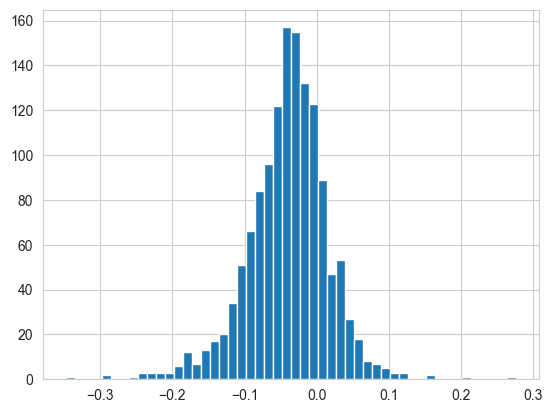

In [165]:
analysis_drop["2d_drop_ext"].hist(bins=50)

In [158]:
analysis_drop.sort_values(by="2d_drop_ext", ascending=True).head(50).style.background_gradient(axis=1).format(precision=3)

,1d_drop_ext,1d_drop_next,2d_drop_ext,2d_drop_next,3d_drop_ext,3d_drop_next,4d_drop_ext,4d_drop_next,5d_drop_ext,5d_drop_next
Date,,,,,,,,,,
2020-03-17 00:00:00,-0.200,-0.270,-0.348,-0.405,-0.334,-0.392,-0.394,-0.447,-0.407,-0.459
2020-03-18 00:00:00,-0.257,-0.094,-0.292,-0.136,-0.423,-0.296,-0.410,-0.281,-0.464,-0.346
2020-02-06 00:00:00,-0.188,-0.116,-0.291,-0.228,-0.126,-0.048,0.052,0.146,0.055,0.149
2020-03-16 00:00:00,-0.272,-0.292,-0.256,-0.276,-0.323,-0.342,-0.338,-0.356,-0.333,-0.351
2020-02-28 00:00:00,-0.173,0.005,-0.248,-0.086,-0.286,-0.132,-0.292,-0.139,-0.330,-0.186
2020-03-19 00:00:00,-0.115,0.056,-0.240,-0.094,-0.276,-0.136,-0.410,-0.296,-0.397,-0.281
2020-09-08 00:00:00,-0.229,-0.144,-0.236,-0.152,-0.311,-0.235,-0.344,-0.271,-0.340,-0.268
2020-03-13 00:00:00,-0.156,-0.251,-0.232,-0.319,-0.249,-0.334,-0.243,-0.329,-0.290,-0.370
2021-03-05 00:00:00,-0.193,-0.158,-0.230,-0.197,-0.252,-0.219,-0.250,-0.217,-0.237,-0.203


# Run through various tickers

In [277]:
def extract_ticker(df_row, russell_list):
    capital = 0
    for letter in df_row:
        if letter.isupper():
            capital += 1
        else:
            break

    
    answer = df_row[:capital-1]
    debug = answer
    white_list = ["SMCI", "MSTR", "NVAX"]

    while len(answer) > 0:
        if answer in (russell_list + white_list):
            return answer
        else:
            answer = answer[:len(answer)-1]
    
    print("Can't find: ", debug)
    return None

russell_table = pd.read_html("https://en.wikipedia.org/wiki/Russell_1000_Index")
russell_list = list(russell_table[2]["Symbol"])


top100 = pd.read_html("https://www.tradingview.com/markets/stocks-usa/market-movers-active/")
ticker_list = list(top100[0]["Symbol"].apply(extract_ticker, russell_list=russell_list))
tickers = [i for i in ticker_list if i is not None]

In [ ]:
data, drop_col, rise_col = extrema_analysis(data)

drop_rank = data.fillna(0)[drop_col]
rise_rank = data.fillna(0)[rise_col]

In [304]:
tickers = ["pltr", "uber", "arm"]
# trading days a year ~250d
for ticker in tickers:
    data = yf.download(ticker, period="1500d", interval="1d", progress=False)

    data, drop_col, rise_col = extrema_analysis(data)    

    if data["drop_flag"].iloc[-1] or data["rise_flag"].iloc[-1]:
        extrema_plot(data[-50:], ticker)
        # break

# yes

In [309]:
tickers = ["pltr", "uber", "arm"]
# trading days a year ~250d
for ticker in tickers:
    data = yf.download(ticker, period="1500d", interval="1d", progress=False)

    data, drop_col, rise_col = extrema_analysis(data)    

    extrema_plot(data[-50:], ticker)


In [328]:
nums = [1,2,3,4]

In [333]:
result = [1] * len(nums)        

for i in range(len(nums) - 1):
    result[i + 1] = nums[i] * result[i]
    print(result)

right = 1
for i in range(-1, -(len(nums)), -1):
    right *= nums[i]
    result[i - 1] = right * result[i - 1]
    print(result)



[1, 1, 1, 1]
[1, 1, 2, 1]
[1, 1, 2, 6]
[1, 1, 8, 6]
[1, 12, 8, 6]
[24, 12, 8, 6]


In [323]:
range(-1, -1, -(len(nums) - 1))

range(-1, -1, -3)